In [1]:
from rnn_shuffle import *
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import warnings
warnings.filterwarnings('ignore')

In [2]:
root = 'texts/'

f = open(root + 'train.txt', 'r')
content = f.read()
print(len(content))
unique_chars = set(content)
unique_chars.add('λ')
chars_lst = sorted(list(unique_chars), key=str)
char_dict = {char:i for i, char in enumerate(chars_lst, 0)}
char_idxs = {i:char for i, char in enumerate(chars_lst, 0)}

379977


In [3]:
#1-hot-encoding where onehot[i] is the 1hotencoding of the ith character
length = len(chars_lst)
onehot = np.zeros((length, length))
for i, char in enumerate(chars_lst, 0):
    onehot[i, i] = 1

In [4]:
def prepare(sample):   
    return torch.LongTensor([[char_dict[i] for i in sample]])

In [5]:
def get_chunks(song):
    chunklst = []
    C = 100 #chunk size
    chunks = len(song) // C
    for idx in range(chunks):
        i = idx * C
        j = (idx+1) * C
        inp = prepare(song[i:j])
        tar = prepare(song[i+1:j+1])
        chunklst.append((inp, tar))
    return chunklst

In [6]:
temp = 1

In [7]:
def tensor_to_char(sample):
    pred_chars = torch.multinomial(F.softmax(sample.div(temp)), 1).view(-1)
    return ''.join(char_idxs[i.item()] for i in pred_chars.to('cpu'))

In [8]:
def to_char(sample):
    return char_idxs[sample.item()]

In [9]:
weight = torch.Tensor(onehot)

In [10]:
# embedding = nn.Embedding.from_pretrained(weight)
hidsz = 501
inpsz = 94
outsz = 94 # vocab size?
num_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pathdir = 'model_states/' + str(hidsz) + 'units'

In [11]:
net = RNnet(inpsz, hidsz, outsz, weight, num_layers).to(device)
criterion = nn.CrossEntropyLoss()

#Instantiate the gradient descent optimizer - use Adam optimizer with default parameters
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [12]:
trainset = loader(root + 'train.txt')
validset = loader(root + 'val.txt')

In [13]:
#deterministic shuffling, helpful when optimizing
shuffle_dataset = True
random_seed= 42

tsize = len(trainset)
vsize = len(validset)
tidxs = list(range(tsize))
vidxs = list(range(vsize))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(tidxs)
    
    np.random.seed(random_seed)
    np.random.shuffle(vidxs)

tsampler = SubsetRandomSampler(tidxs)
vsampler = SubsetRandomSampler(vidxs)

In [14]:
train = DataLoader(trainset, batch_size=1,
                  sampler=tsampler)

valid = DataLoader(validset, batch_size=1,
                  sampler=vsampler)

In [15]:
states = None
epochs = 25
N = 50

 #early stopping
stop = True
#training and validation losses
tloss = []
vloss = []

#used with early stopping to save the best model
#with the lowest validation loss
best_loss = float('inf')


#resets the seed within generational runs but still sample
#songs still randomized within each epoch
torch.manual_seed(random_seed)

#epochs loop
for itrs in range(epochs):
    
    #list to hold loss of each sample song within an epoch
    epochloss = []
   
    #forward pass
    for i, song in enumerate(train, 0):
        song = song[0]
        trainloss = 0
        minibatchloss = 0
        xnloss = []
        states = None
        
        #use BPTT(100) in chunks of 100 characters
        #from each song
        for inputs, targets in get_chunks(song):
            
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs, states = net(inputs, states)
            targs = torch.squeeze(targets)
            print('Epoch [%d] minibatch [%d]\r' % (itrs+1, i), end="")

            loss = criterion(outputs, targs)
            loss.backward()
            optimizer.step()

            trainloss += loss.item()      
            xnloss.append(loss.item())

            if i % N == 49:
                #Print the loss averaged over the last N mini-batches
                print('\tEpoch %d, running %d loss: %.3f\r' % (1,i+1, trainloss), end="")
                trainloss = 0

        #get the average loss for each sample song
        song_loss = np.average(xnloss)
        epochloss.append(song_loss)
    
    #average loss of training set for each epoch
    eploss = np.average(epochloss)
                
    print('Epoch [%d] train loss is (%.3f)' % (itrs+1, eploss)) 
    tloss.append(eploss)
    
    
    epochloss = []
    songout = '<'

    #validation performance to see how our trained model does 
    #on unseen songs, saves the model if it has the lowest loss
    with torch.no_grad():
        for i, song in enumerate(valid, 0):
            song = song[0]
            validloss = 0
            minibatchloss = 0
            xncost = []
            states = None
            for inputs, targets in get_chunks(song):
            
                inputs = inputs.to(device)
                targets = targets.to(device)

                outputs, states = net(inputs, states)

                targs = torch.squeeze(targets)
                loss = criterion(outputs, targs).item()

                validloss += loss
                xncost.append(loss)

                if i % N == 49:
                    validloss /= N
                    print('\tEpoch %d, valid %d loss: %.3f\r' % (1,i+1, validloss), end="")
                    validloss = 0
                    
                if i == 0:
                    songout += tensor_to_char(outputs)
            
            eploss = np.average(xncost)
            epochloss.append(eploss)
    
        ep_loss = np.average(epochloss).round(4)
        print('Epoch [%d] valid loss is (%.4f)' % (itrs+1, ep_loss)) 

        if len(vloss) < 2:
            vloss.append(ep_loss)
        elif vloss[-2] <= vloss[-1] <= ep_loss:
            vloss.append(ep_loss)
            if stop:
                print("EARLY STOPPED AT EPOCH: ", itrs + 1)
                print("models[-2] has the lowest valid error?")
                break
        else:
            vloss.append(ep_loss)
            
    #print a sample generated song every 3 epochs
    if itrs % 3 == 0:
        print('---------------------------------')
        print('GENERATED SONG AT EPOCH [{}]'.format(itrs+1))
        print(songout)
        print('---------------------------------')
    
#     path = 'model_states/states_' + 'ep' + str(itrs+1) + '.pt'
    #if we got a better loss, save the model_state_dict()
    if vloss[-1] < best_loss:
        path = pathdir +  '.pt'
        torch.save(net.state_dict(), path)
        print('new best loss')
        best_loss = vloss[-1]

    print()

Epoch [1] train loss is (2.070)50
Epoch [1] valid loss is (1.7142)
---------------------------------
GENERATED SONG AT EPOCH [1]
<ssart>
X:11T:Ai pei !ot Ca nte  hl saa"snaylc:BoahSurob
Z:Crra  Fhankanss
{arsimn ineGalt os lh  paew edorttu dhe ter,ygelessi 3:-elsin oala t an m?vg,ide
MirtsgnsSfwraise
u5/Z:Jrrc ueeosyat  aaemhab rilSoasdazeFo toikekPoaiea,uR:Oi? andvooyt>
W:Td:hn-harh1ggerG9M:6|
K:G
oj
~B fr|f ~2gA fc ccBA2|f|dG5Fd e3ccA|AD :|
|2af ecGc3(cB A3Acc A3AAG |B||dGBd3BE DF ec+FA||B||
P:34E(Bc2 BBBf|(dff d3fd|(abealR|'ad_nrcd du.danees
)tBeusasr"cneB17nf Me-i c.g  e|ud||f2dff BBAA.(GeBd|D, GF|:|dG2df fff|:|dB cfcfBc|=3BdG egA\A |3F||AD2cF gd e3cdF,A3DGd B3"AG GG||C6A(BFB \BAA3AGB|AB||
|:varoations
C  c3 d2|df?||(dcd3|d c|ce|||~6Gf3ccd GB:F|cBd B BggG3DdA| 2dd3B/G||F:AdFTGeF =D2G2 AFG|
<:ADAAGe |AFed|mabg7A}f2/d fcfgef2gfgfgd Af g|aZ3ea Bfff|(3 Ad egB^c3|||da (3 eF G3 f|f:ecG3 aff||f2ed3ffe=||>/c G}ee3dcG|AFBD|BG2GG df cAcBB]
Gd:FGdG|A :D~|FFdFA 
2BdA3~(gB ||F |
<end>
λλλλλλλλλ

In [16]:
minloss = np.argmin(vloss)
minloss

4

In [17]:
loss_str = str(int((vloss[minloss] - 1).round(4) * 1000))
loss_str

'303'

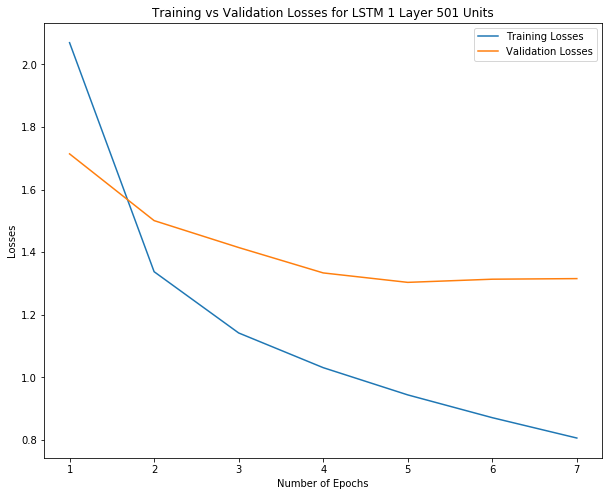

In [18]:
#loss graph
graph_title = 'Training vs Validation Losses for LSTM 1 Layer ' + str(hidsz) + ' Units'

fig = plt.figure(figsize=(10, 8))
ax = plt.subplot()
ax.plot(np.arange(1, len(tloss) + 1), tloss, label='Training Losses')
ax.plot(np.arange(1, len(vloss) + 1), vloss, label='Validation Losses')
ax.set(xlabel='Number of Epochs', ylabel='Losses',
           title=graph_title)
leg = ax.legend() #loc=4)
fig.savefig('graphs/' + str(hidsz) + 'units_vloss' + loss_str + '.png')

In [21]:
#load the best model and generating music using its learned weights
bestmodelpath = pathdir + '.pt'
savepath = pathdir + loss_str + '.pt'
makesong_net = RNnet(inpsz, hidsz, outsz, weight, num_layers)
makesong_net.load_state_dict(torch.load(bestmodelpath))
makesong_net = makesong_net.to(device)
torch.save(makesong_net.state_dict(), savepath)
makesong_net.eval()

RNnet(
  (char_embeddings): Embedding(94, 94)
  (lstm): LSTM(94, 501)
  (hidden2out): Linear(in_features=501, out_features=94, bias=True)
)

In [23]:
input_char = '<' # make longer if not doing it right '<start>'
input_string = '<start>\nX:'
temp = 0.8
inp_str = input_string

inputs = prepare(inp_str).to(device)
initial_output, initial_state = makesong_net(inputs, None)

pls_work = torch.multinomial(F.softmax(initial_output.div(temp)), 1)
lastchar = to_char(pls_work[-1])

inp_str += lastchar
print(inp_str)
print()

while '<end>' not in inp_str:
# for _ in range(1000):
    inputs = prepare(inp_str).to(device)
    output, initial_state = makesong_net(inputs, None)
    pls_work = torch.multinomial(F.softmax(output.div(temp)), 1)
    lastchar = to_char(pls_work[-1])
    inp_str += lastchar
    
    if 'λ' in inp_str:
        break

print("--------- Generated song ---------")
print(inp_str)

<start>
X:4

--------- Generated song ---------
<start>
X:42
T:Scout madA Bourr?e
O:France
A:Provence
C:Trad.
R:Marche
S:Carnet du tambourinaire Ginas (1924)
R:Danse trad.
O:France
A:Provence
C:Trad.
R:Michelonde
Z:Transcrit et/ou corrig? par Michel BELLON - 2007-08-13
Z:Pour toute observation mailto:galouvielle@free.fr
M:4/2
L:1/4
Q:1/4=180
K:Cbmaj
V:1
"D"BA/G/ FG | "C"cB/c/ "G"FF | "F"GF BB "Am"BA/B/ | "C"c2 "A"AG AB | "G"dd cA | "G"e>d cB | "C"B>A Be | "G"dB "D"e>d | "G"dc BG "C"c2 |:
"B"GF GB "C7"EG | "F"cB "A"A2G :|
L:1/8
":"Mdc6 "G"A2 "B"Dd/2d/2| "C"e3 z3|
"F"f2a fed|"C"e2f edc|BEF GAB|"C"edc "G7"d2d|"C"c2G "F"A2:|
"C"c2c "C"e2d|"G"d2z "3"fed|"C"e2e "G"d2d|"C"e2e "F"c2 :|
"C"Con dermen""|"G"Md2 d|"C"c2c "G"d|"G"c2 "C"cA|BdcB A2|"G"B2"D"A3:|
"D"d2d "C"e2d|"C"e2e f2g|"C"e2e "C"e2f|"C"efe "G"dGA|"G"B2A "F7"d2d|"C"e2c "C"c2e|"G"d2c "Am"ecd|"C"e2a "C"e2c|"
"efe "G"d2d|"C"e^d "G"dde|"C"eec "C"e2d|"C"e2c "C"e2""|"D2A "G7"d2G|"G"G3 "G"d2d|"C"e3 d3|"C"c2z "C"c2z|"C"c2d "G7"d2B|d2d d2d|"C"

Use the following website to convert ABC notation to playable music in midi format.  
http://mandolintab.net/abcconverter.php

In [ ]:
#for saving songs  
#songname = 'songs/goodtune.txt'  
#songpath = 'songs/' + str(hidsz) + 'units_song' + str(count) + '.txt'  
#f = open(songname, "w")  
#f.write(inp_str)  
#f.close()  